In [184]:
import pandas as pd
import requests
from time import sleep
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib import ticker

In [2]:
api_url = "https://mon-entreprise.urssaf.fr/api/v1/evaluate"

In [3]:
def get_response(n: int):
    request = {
        "situation": {
            "entreprise . imposition": "non",
            "entreprise . catégorie juridique": "''",
            "impôt . méthode de calcul": "'barème standard'",
            "salarié . activité partielle": "non",
            "salarié . contrat": "'CDI'",
            "salarié . rémunération . net . payé après impôt": n,
            "dirigeant": "non",
        },
        "expressions": [
            "salarié . coût total employeur",
            "salarié . contrat . salaire brut",
            "salarié . rémunération . net . à payer avant impôt",
            "salarié . rémunération . net . payé après impôt",
        ],
    }
    sleep(0.3)
    response = requests.post(api_url, json=request, verify=False)
    expressions = [a.get("nodeValue", pd.NA) for a in response.json()["evaluate"]]
    return {
        "coût total employeur": expressions[0],
        "salaire brut": expressions[1],
        "rémunération avant impôt": expressions[2],
        "rémunération après impôt": expressions[3]
    }

In [4]:
resp = get_response(100)

/home/solal/.cache/pypoetry/virtualenvs/marginal-prel-kdBzckJP-py3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mon-entreprise.urssaf.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
resp

{'coût total employeur': 178.99695287061922,
 'salaire brut': 154.04293217196872,
 'rémunération avant impôt': 100,
 'rémunération après impôt': 100}

In [121]:
responses_0 = [get_response(n) for n in tqdm(range(0,4500,10))]
responses_1 = [get_response(n) for n in tqdm(range(4500,15000,200))]

  0%|          | 0/450 [00:00<?, ?it/s]/home/solal/.cache/pypoetry/virtualenvs/marginal-prel-kdBzckJP-py3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mon-entreprise.urssaf.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 1/450 [00:00<04:47,  1.56it/s]/home/solal/.cache/pypoetry/virtualenvs/marginal-prel-kdBzckJP-py3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mon-entreprise.urssaf.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 2/450 [00:03<13:27,  1.80s/it]/home/solal/.cache/pypoetry/virtualenvs/marginal-prel-kdBzckJP-py3.11/lib/python3.11/site-packages/urllib3/co

In [122]:
responses = responses_0 + responses_1
df = pd.DataFrame(responses)

In [123]:
df

,coût total employeur,salaire brut,rémunération avant impôt,rémunération après impôt
0,20,0,0,0
1,<NA>,<NA>,<NA>,10
2,<NA>,<NA>,<NA>,20
3,87.724305,65.614154,30,30
4,100.763255,78.246836,40,40
...,...,...,...,...
498,38748.326744,27421.354173,21906.36684,14100
499,39438.736564,27918.67443,22304.421974,14300
500,40128.899732,28415.817017,22702.3349,14500
501,40819.144182,28913.018154,23100.29469,14700


In [410]:
df.to_csv("df.csv")

In [411]:
no_zeros = df[~df.isna().any(axis=1)].reset_index(drop=True)

In [412]:
no_zeros

,coût total employeur,salaire brut,rémunération avant impôt,rémunération après impôt
0,20,0,0,0
1,87.724305,65.614154,30,30
2,100.763255,78.246836,40,40
3,113.802204,90.879519,50.0,50
4,126.841154,103.512202,60.0,60
...,...,...,...,...
496,38748.326744,27421.354173,21906.36684,14100
497,39438.736564,27918.67443,22304.421974,14300
498,40128.899732,28415.817017,22702.3349,14500
499,40819.144182,28913.018154,23100.29469,14700


In [413]:
no_zeros["cout marginal employeur"] = (no_zeros - no_zeros.shift(1))["coût total employeur"]
no_zeros["net apres impots marginal"] = (no_zeros - no_zeros.shift(1))["rémunération après impôt"]

In [415]:
no_zeros = no_zeros.iloc[2:]
no_zeros = no_zeros.astype(float)
no_zeros["tx prelevement marginal"] = (1 - no_zeros["net apres impots marginal"] / no_zeros["cout marginal employeur"]).round(2)
no_zeros["tx prelevement total"] = 1- no_zeros["rémunération après impôt"]/no_zeros["coût total employeur"].round(3)
no_zeros["revenu net imposable"] = no_zeros["rémunération avant impôt"]*12*0.9

In [348]:
def custom_smic_formatter(x, pos):
    if 1360 < x < 1405:
        return f"{x:.0f}\nSMIC"
    else:
        return f"{x:.0f}"

In [387]:
print(plt.style.available)
plt.style.use("default")

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


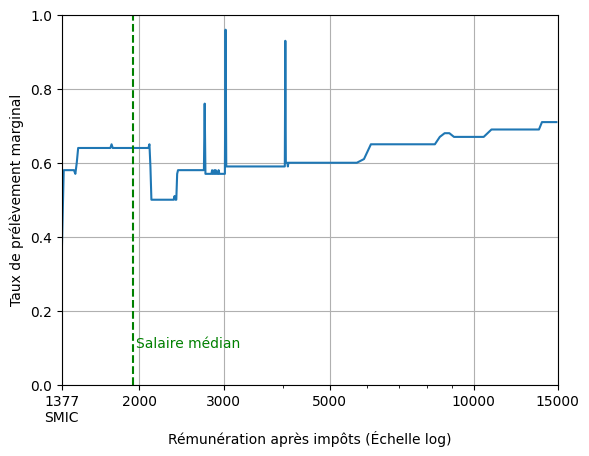

In [416]:
fig, ax = plt.subplots()
plt.grid(True)
plt.ylim(0,1)
plt.xlim(1377,15000)
ax.plot(no_zeros["rémunération après impôt"], no_zeros["tx prelevement marginal"].astype(float).round(2))
plt.xlabel("Rémunération après impôts (Échelle log)")
plt.ylabel("Taux de prélèvement marginal")
# plt.axvline(x=1400, color="b", linestyle="--")
# plt.text(1300, -0.057, "SMIC", alpha=0.7)

plt.axvline(x=1940, color='g', linestyle='--')
plt.text(1970,0.1, 'Salaire médian', color='g')
plt.xscale("log")
ax.xaxis.set_major_locator(ticker.FixedLocator([1377, 2000,3000,5000,10000,15000]))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_smic_formatter))
plt.savefig("Images/TauxMarginal.png", dpi=1000)
plt.show()

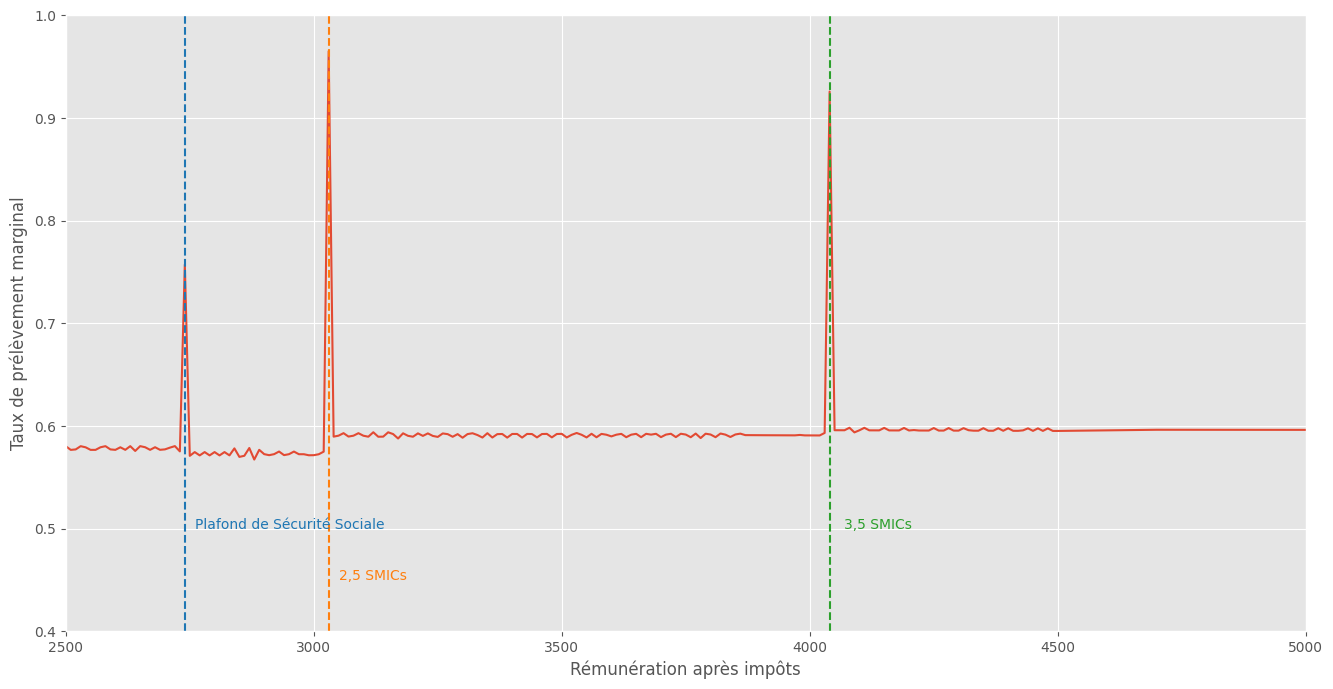

In [329]:
cmap = plt.color_sequences['tab10']

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.ylim(0.4,1)
plt.xlim(2500,5000)
ax.plot(no_zeros["rémunération après impôt"], no_zeros["tx prelevement marginal"])
plt.xlabel("Rémunération après impôts")
plt.ylabel("Taux de prélèvement marginal")
plt.axvline(x=2740, color=cmap[0], linestyle='--')
plt.text(2760,0.5, 'Plafond de Sécurité Sociale', color=cmap[0])
plt.axvline(x=3030, color=cmap[1], linestyle='--')
plt.text(3050,0.45, '2,5 SMICs', color=cmap[1])
plt.axvline(x=4040, color=cmap[2], linestyle='--')
plt.text(4070,0.5, '3,5 SMICs', color=cmap[2])
plt.show()

<!-- On observe aussi une grosse bosse après avoir atteint le SMIC, aux 1398€ mensuels nets. -->

Avec le "Plafond de Sécurité Sociale" (3864€ bruts, ~2720€ nets après impôts), il y a l'introduction de la contribution à l'équilibre général (0.21%+0.14%).

À 2.5 SMIC bruts (~3030€ nets après impôts, 4375€ mensuels brut, ~52500€ annuels brut), les cotisations employeurs de l'assurance maladie passent du taux réduit à 7% au taux plein qui est de 13% -- et ce sur toute l'assiette. Ceci forme un seuil où le taux marginal de prélèvement est à plus de 100%. Ainsi, en dépassant ce seuil de 1€ sur le brut, on obtient un surcrois d'environ 270€ de prélèvements.

<!-- Sur le simulateur directement, cela semble par contre fragile: quand on essaye d'inspecter spécifiquement cette variable, elle semble rester coincée en taux plein parfois. -->

À 3.5 SMIC bruts (~4030€ nets après impôts, 6125€ mensuels brut, 73500€ annuels brut), oû les allocations familiales passent du taux réduit à 3.45% à 5.25%. On a donc une regressivité sur environ 110€.

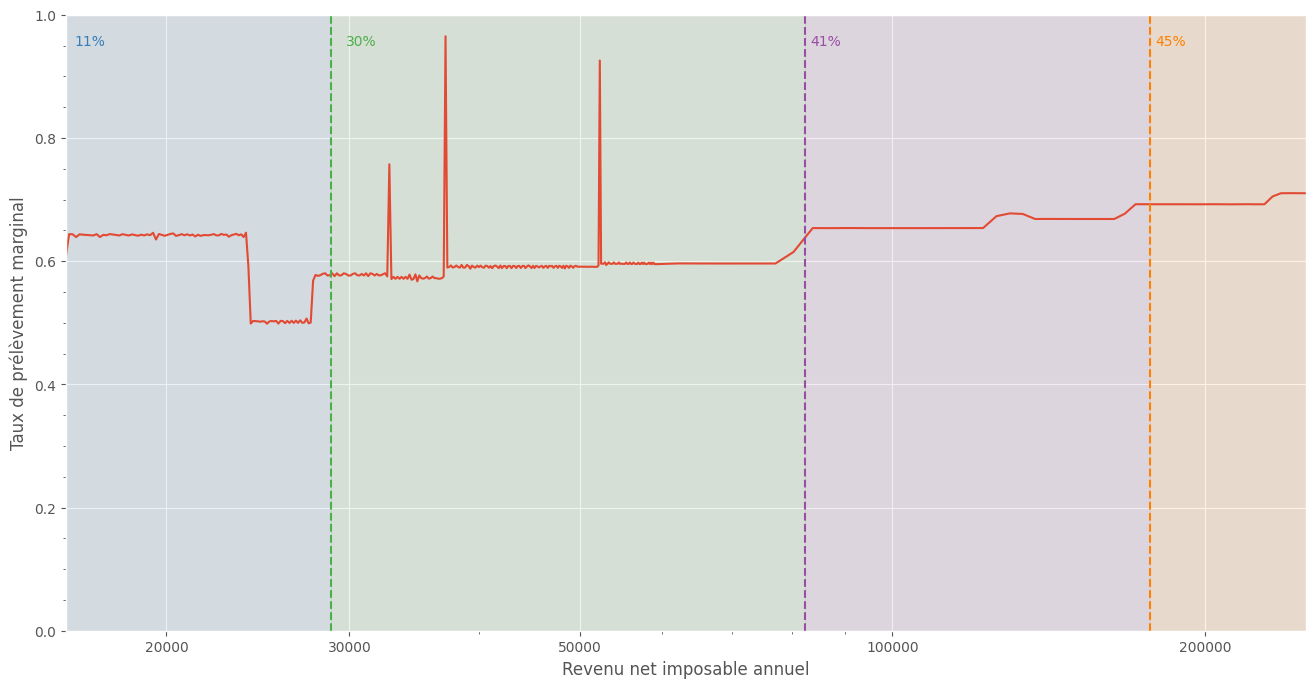

In [330]:
cmap = plt.color_sequences['Set2']
tranches = [(0, 0), (11294, 11), (28797, 30), (82342, 41), (177106, 45)]

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(8)
ax.plot(no_zeros["revenu net imposable"], no_zeros["tx prelevement marginal"])
plt.xlim(16000, 250000)
plt.ylim(0,1)
for i, tranche in enumerate(tranches[:-1]):
    if i == 0: continue
    x_section = np.linspace(tranche[0], tranches[i+1][0], 100)
    plt.fill_between(x_section, 0, 1, color=cmap[i], alpha=0.1)
    plt.axvline(x=tranche[0], color=cmap[i], linestyle='--')
    if i == 1:
        plt.text(tranche[0]+5000,0.95, f"{tranche[1]}%", color=cmap[i])
    else:
        plt.text(tranche[0]+1000,0.95, f"{tranche[1]}%", color=cmap[i])
max_x = max(no_zeros["revenu net imposable"])
tranche = tranches[-1]
i = len(tranches) - 1
x_section = np.linspace(tranche[0], max_x, 100)
plt.fill_between(x_section, 0, 1, color=cmap[i], alpha=0.1)
plt.axvline(x=tranche[0], color=cmap[i], linestyle='--')
plt.text(tranche[0]+2000,0.95, f"{tranche[1]}%", color=cmap[i])

plt.xlabel("Revenu net imposable annuel")
plt.ylabel("Taux de prélèvement marginal")


plt.xscale("log")
plt.minorticks_on()
ax.xaxis.set_major_locator(ticker.FixedLocator([20000,30000,50000,100000,200000]))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_smic_formatter))
plt.show()

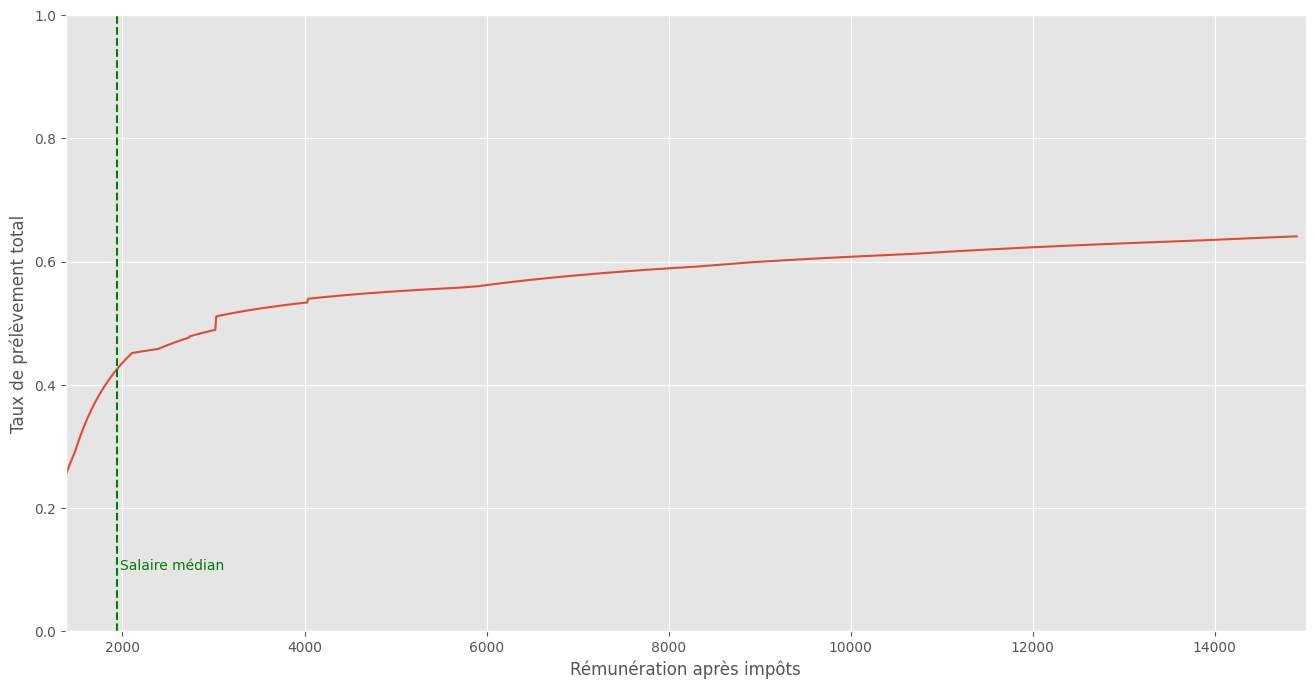

In [341]:
cmap = plt.color_sequences['tab10']

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.ylim(0,1)
plt.xlim(1377,15000)
ax.plot(no_zeros["rémunération après impôt"], no_zeros["tx prelevement total"])
plt.xlabel("Rémunération après impôts")
plt.ylabel("Taux de prélèvement total")
plt.axvline(x=1940, color='g', linestyle='--')
plt.text(1970,0.1, 'Salaire médian', color='g')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_smic_formatter))
plt.show()

In [119]:
no_zeros[(no_zeros["revenu net imposable"] > 250000) & (no_zeros["revenu net imposable"] < 300000)]

,coût total employeur,salaire brut,rémunération avant impôt,rémunération après impôt,cout marginal employeur,net apres impots marginal,tx prelevement marginal,revenu net imposable
204,41509.210975,29410.091320,23498.152052,14900,690.066793,200.0,0.710173,253780.042164
205,42199.235052,29907.133716,23895.984786,15100,690.024077,200.0,0.710155,258076.635691
206,42889.486962,30404.340226,24293.948877,15300,690.251910,200.0,0.710251,262374.647871
207,43579.804741,30901.594183,24691.950944,15500,690.317779,200.0,0.710278,266673.070198
208,44129.764088,31343.705470,25088.382978,15700,549.959347,200.0,0.636337,270954.536159
209,44676.624333,31784.558255,25484.709631,15900,546.860245,200.0,0.634276,275234.864016
210,45223.619943,32225.520164,25881.134388,16100,546.995610,200.0,0.634366,279516.251387
211,45770.671016,32666.526785,26277.599340,16300,547.051073,200.0,0.634403,283798.072874
212,46317.692623,33107.509652,26674.042937,16500,547.021607,200.0,0.634384,288079.663723
213,46864.674653,33548.460614,27070.457852,16700,546.982030,200.0,0.634357,292360.944799


In [379]:
no_zeros.to_csv("prel_marg.csv")

In [3]:
no_zeros = pd.read_csv("prel_marg.csv")

In [4]:
no_zeros

,Unnamed: 0,coût total employeur,salaire brut,rémunération avant impôt,rémunération après impôt,cout marginal employeur,net apres impots marginal,tx prelevement marginal,revenu net imposable
0,0,2146.811976,1927.752276,1504.063883,1500,NaN,NaN,NaN,16243.889932
1,1,2202.570797,1957.357270,1527.499121,1520,55.758821,20.0,0.641312,16496.990512
2,2,2258.548435,1987.065434,1551.016030,1540,55.977638,20.0,0.642714,16750.973121
3,3,2314.400962,2016.772113,1574.531763,1560,55.852527,20.0,0.641914,17004.943036
4,4,2370.180615,2046.375681,1597.965874,1580,55.779653,20.0,0.641446,17258.031434
...,...,...,...,...,...,...,...,...,...
270,270,16265.470636,11352.003855,9053.385117,6900,57.579395,20.0,0.652654,97776.559269
271,271,16323.051320,11392.248679,9085.721733,6920,57.580685,20.0,0.652661,98125.794718
272,272,16380.633288,11432.494400,9118.059069,6940,57.581968,20.0,0.652669,98475.037949
273,273,16438.216532,11472.741013,9150.397122,6960,57.583244,20.0,0.652677,98824.288919


In [5]:
import seaborn as sbn

<Axes: xlabel='rémunération après impôt', ylabel='tx prelevement marginal'>

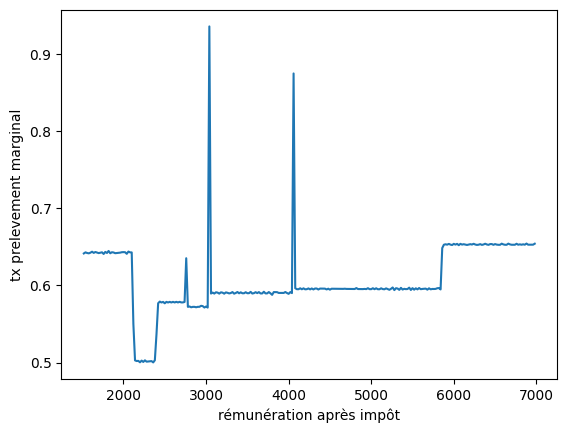

In [8]:
sbn.lineplot(x=no_zeros["rémunération après impôt"], y=no_zeros["tx prelevement marginal"],)